# Two Actors at the Price of One
#  or Training PPO with DQN as a critic with [ReLAx](https://github.com/nslyubaykin/relax)

For ReLAx & Mujoco installation see: https://github.com/nslyubaykin/relax/blob/master/README.md

Useful readings regarding DQN:

- DQN paper: https://arxiv.org/pdf/1312.5602.pdf
- PPO paper: https://arxiv.org/pdf/1707.06347
- PPO description: https://spinningup.openai.com/en/latest/algorithms/ppo.html

!Note: For examining trained actor you may just load trained policies from \trained_models directory. To do that instead of running 'Run Training and Validation loop' cell, just run 'Load Models' cell

!Note: Trained policies, logs and videos are in the main repository of that notebook: https://github.com/nslyubaykin/ppo_with_dqn_critic

In [1]:
import gym
import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from inspect import getsource
from torch.utils.tensorboard import SummaryWriter

from relax.rl.critics import DQN
from relax.rl.actors import ArgmaxQValue, PPO

from relax.zoo.policies import CategoricalMLP
from relax.zoo.critics import DiscQMLP

from relax.schedules import PiecewiseSchedule, LinearSchedule, CombinedSchedule, ConstantSchedule
from relax.exploration import EpsilonGreedy

from relax.gym.utils import get_wrapper_by_name, visualize_actor
from relax.gym.wrappers.atari import *

from relax.data.sampling import Sampler
from relax.data.replay_buffer import ReplayBuffer

/home/nikita/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Defining PPO actor and DQN critic

For this tutorial we will use PPO and DQN as a base algorithms. For brevity of the tutorial detailed PPO and DQN explanation will be omitted. They may be found here: [PPO](https://github.com/nslyubaykin/relax_ppo_example/blob/master/ppo_example.ipynb), [DQN](https://github.com/nslyubaykin/relax_dqn_example/blob/master/dqn_tutorial.ipynb)

# Overall Idea

PPO needs and estimation of advantages to run the training process. Typically advantages for PPO are estimated with GAE-$\lambda$ algorithm. 

This notebook explores the possibility of training PPO in pair with DDQN critic.

While PPO is trained in on-policy mode using transitions sampled with its policy network, DQN is trained on off-policy data stored in replay buffer (which is filled with train batches sampled with PPO actor)

Advantages are computed by definition:

$ \hat{A}^{\pi}(A_{t}, S_{t}) = \hat{Q}^{\pi}_{\phi}(A_{t}, S_{t}) - \hat{V}^{\pi}_{\phi}(S_{t})$

where $\hat{V}^{\pi}_{\phi}(S_{t})$ is computed not by its "greedy" definition: ${\max}_{a \in A}({q}_{\phi}({S}_{t}, a)$, but by averaging Q-values over all possible actions: $  \frac{1}{|A|} \sum_{a \in A} \hat{Q}^{\pi}_{\phi}(a, S_{t}) $

!Note: Original greedy estimation may be used by specifying `greedy_value=True` in `DQN` `__init__`

Theoretically, such procedure should allow us to train 2 agents (`PPO`+`DQN` and `ArgmaxQValue`+`DQN`) on the same samples.

# Create training and eval environments

On practice, when training DQN on Atari 2600 domain, algorithm is not fed with raw environment observations, instead several wrappers are applied:

1) EpisodicLifeEnv - make end-of-life == end-of-episode, but only reset on true game over. Done by DeepMind for the DQN and co. since it helps value estimation

2) NoopResetEnv - Sample initial states by taking random number of no-ops on reset. No-op is assumed to be action 0.

3) MaxAndSkipEnv - Return only every skip-th frame and do max-pooling over most recent two observations

4) FireResetEnv - Take action on reset for environments that are fixed until firing.

5) ClipRewardEnv - Bin reward to {+1, 0, -1} by its sign.

In [2]:
def makeenv(env_name, seed):
    
    env = gym.make(env_name)
    ob_unwrap = env.reset()
    
    env = gym.wrappers.Monitor(
        env,
        'monitor_train_logs',
        force=True,
        video_callable=None,
    )
    
    env = wrap_deepmind_ram(
        env
    )
    
    env.seed(seed)
    
    ob = env.reset()
    
    return env, ob_unwrap, ob 

In [3]:
env_name = 'Atlantis-ram-v0'


env, ob_unwrap, ob = makeenv(
    env_name=env_name, seed=12
)

ppo_eval_env, _, _ = makeenv(
    env_name=env_name, seed=27
)

dqn_eval_env, _, _ = makeenv(
    env_name=env_name, seed=27
)


print(ob_unwrap.shape, ob.shape)

(128,) (128,)


In [4]:
env.action_space

Discrete(4)

In [5]:
obs_dim = 128
acs_dim = 4

# Define Function For Observation Pre-Processing:

Scale from 0 to 255. to 0 to 1.

In [6]:
import torch

from torch import nn

class PreprocessRam(nn.Module):
    
    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        return x / 255.

# Define PPO Actor:

In [7]:
ppo_actor = PPO(
    policy_net=CategoricalMLP(obs_dim=obs_dim, acs_dim=acs_dim, 
                              nlayers=2, nunits=256, 
                              pre_process_module=PreprocessRam()),
    device=torch.device('cuda'),
    learning_rate=2e-4, 
    n_epochs_per_update=20,
    batch_size=2184,
    target_kl=1.0,
    eps=0.2,
    gamma=0.99
)

# Define ArgmaxQValue Actor

In [8]:
argmax_q_actor = ArgmaxQValue()

# Define DQN Critic:

In [9]:
critic = DQN(
    critic_net=DiscQMLP(obs_dim=obs_dim, acs_dim=acs_dim, 
                        nlayers=2, nunits=512, 
                        pre_process_module=PreprocessRam()),
    device=torch.device('cuda'),
    learning_rate=1e-4,
    batch_size=32,
    gamma=0.99,
    target_updates_freq=10000,
    n_steps_per_update=20000,
    update_freq=4,
    double_q=True
)

# Provide Actors with Critic

In [10]:
ppo_actor.set_critic(critic)
argmax_q_actor.set_critic(critic)

# Wrap envs into Sampler:

In [11]:
sampler = Sampler(env=env)
ppo_eval_sampler = Sampler(env=ppo_eval_env)
dqn_eval_sampler = Sampler(env=dqn_eval_env)

# Create replay buffer for DQN

In [12]:
replay_buffer = ReplayBuffer(int(1e6)) 

# Visualize untrained actor (PPO)

In [13]:
visualize_actor(env=ppo_eval_env, actor=ppo_actor, nsteps=1000, train_sampling=False)

Simulation done, total reward: 0.0
Loading video...


# Visualize untrained actor (DQN)

In [14]:
visualize_actor(env=dqn_eval_env, actor=argmax_q_actor, nsteps=1000, train_sampling=False)

Simulation done, total reward: 1.0
Loading video...


# Run Training and Validation loop:

In [14]:
n_steps = 500
logdir = '/home/nikita/Desktop/RelaxExamples/PPO_DQN/tensorboard_logs'
run_name = f'ppo_ddqn_{env_name}'
logger = SummaryWriter(log_dir=f'{logdir}/{run_name}')
all_logs = []

for step in tqdm(range(n_steps)): 
    
    # sample training batch
    train_batch = sampler.sample(actor=ppo_actor, # sample with on-policy actor
                                 n_transitions=20000,
                                 max_path_length=None, 
                                 reset_when_not_done=False,
                                 train_sampling=True)
    
    # Add training batch to replay buffer
    replay_buffer.add_paths(train_batch)
    
    # update critic on replay buffer (off policy)
    critic_logs = critic.update(replay_buffer)
        
    # update PPO actor on current batch (on policy)
    ppo_actor_logs = ppo_actor.update(train_batch)
    
    # update ArgmaxQValue actor (Only steps schedules)
    argmax_q_actor_logs = argmax_q_actor.update(replay_buffer)
     
    # evaluating the policy (PPO)
    ppo_eval_batch = ppo_eval_sampler.sample_n_episodes(
        actor=ppo_actor,
        n_episodes=10,
        max_path_length=None, 
        train_sampling=False
    )
    ppo_eval_logs = ppo_eval_batch.create_logs(prefix='eval_ppo')
    
    # evaluating the policy (ArgmaxQValue)
    dqn_eval_batch = dqn_eval_sampler.sample_n_episodes(
        actor=argmax_q_actor,
        n_episodes=10,
        max_path_length=None, 
        train_sampling=False
    )
    dqn_eval_logs = dqn_eval_batch.create_logs(prefix='eval_dqn')
    
    # Logging
    train_logs = train_batch.create_logs(prefix='train_ppo')
    buffer_logs = replay_buffer.create_logs(prefix='buffer_dqn')
      
    logs = {**critic_logs,
            **ppo_actor_logs,
            **argmax_q_actor_logs,
            **train_logs,
            **buffer_logs,
            **ppo_eval_logs,
            **dqn_eval_logs}
    all_logs.append(logs)

    for key, value in logs.items():
        logger.add_scalar(key, value, step)
    
logger.flush()

100%|██████████| 500/500 [12:39:07<00:00, 91.09s/it]  


In [28]:
%load_ext tensorboard
%tensorboard --logdir /home/nikita/Desktop/RelaxExamples/PPO_DQN/tensorboard_logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6007 (pid 66613), started 22:21:43 ago. (Use '!kill 66613' to kill it.)

# Plot learning curve

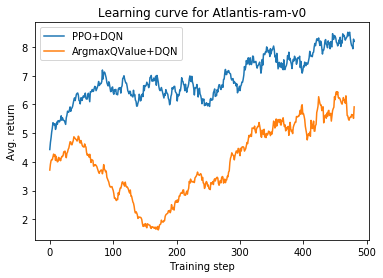

In [17]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

ppo_eval_score = moving_average(
    [l['avg_return/eval_ppo'] for l in all_logs], 20
)

dqn_eval_score = moving_average(
    [l['avg_return/eval_dqn'] for l in all_logs], 20
)


plt.plot(ppo_eval_score, label='PPO+DQN')
plt.plot(dqn_eval_score, label='ArgmaxQValue+DQN')
plt.title(f'Learning curve for {env_name}')
plt.legend()
plt.xlabel('Training step')
plt.ylabel('Avg. return')
plt.show()

# Plot estimated vs actual Q-values

('avg_return', 7.0)
('std_return', 8.882567196480982)
('max_return', 32.0)
('min_return', 0.0)
('mean_pathlen', 73.85)
('n_paths', 20)
('n_transitions', 1477)


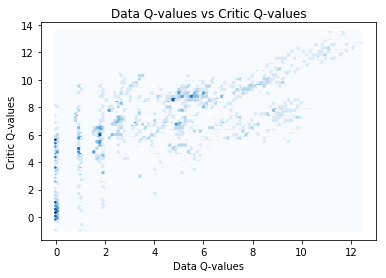

In [19]:
batch = ppo_eval_sampler.sample_n_episodes(actor=ppo_actor,
                                           n_episodes=20,
                                           max_path_length=None, 
                                           train_sampling=False)

print(*batch.create_logs().items(), sep='\n')

batch.add_disc_cumsum(cumsum_field='q_vals', field='rews', gamma=0.99)
data_q_values = batch.unpack(['q_vals'])

model_q_values = critic.estimate_qvalue(batch)

plt.hexbin(data_q_values, model_q_values, bins=50, cmap=plt.cm.Blues)
plt.title('Data Q-values vs Critic Q-values')
plt.xlabel('Data Q-values')
plt.ylabel('Critic Q-values')
plt.show()

# Visualize trained actor (PPO)

In [25]:
visualize_actor(env=ppo_eval_env, actor=ppo_actor, nsteps=1000, train_sampling=False)

Simulation done, total reward: 31.0
Loading video...


# Visualize trained actor (DQN)

In [27]:
visualize_actor(env=dqn_eval_env, actor=argmax_q_actor, nsteps=1000, train_sampling=False)

Simulation done, total reward: 7.0
Loading video...


# Save Models

In [23]:
ppo_actor.save_checkpoint('trained_models', 'ppo_actor')
argmax_q_actor.save_checkpoint('trained_models', 'argmax_q_value_actor')
critic.save_checkpoint('trained_models', 'dqn_critic')

Saved checkpoints for PPO...
models_state_dict global_step n_updates optimizer scheduler
Saved checkpoints for ArgmaxQValue...
global_step
Saved checkpoints for DQN...
models_state_dict global_step local_step n_updates n_target_updates optimizer scheduler


/home/nikita/.local/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


# Load Models

In [ ]:
ppo_actor.load_checkpoint('trained_models', 'ppo_actor')
argmax_q_actor.load_checkpoint('trained_models', 'argmax_q_value_actor')
critic.load_checkpoint('trained_models', 'dqn_critic')